/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
           Random Forest      LSTM  Decision Tree
Accuracy        0.963095  0.978916       0.935025
Precision       0.963368  0.979541       0.908992
Recall          0.935742  0.965309       0.909522
F1 Score        0.949119  0.971853       0.908705
FPR             0.019118  0.010892       0.053785
FNR             0.064258  0.034691       0.090478
TSS             0.916625  0.954417       0.855738
HSS             0.919317  0.954577       0.856537


<Figure size 1000x600 with 0 Axes>

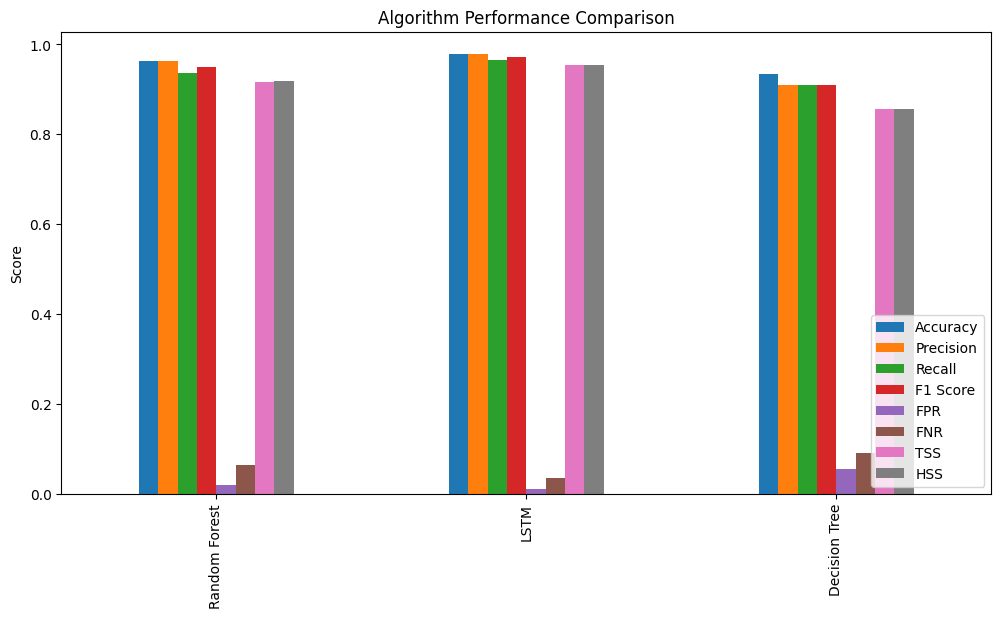

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Step 2: Load and Preprocess Data
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
columns = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(data_url, names=columns)

# Drop ID column
data.drop('ID', axis=1, inplace=True)

# Encode labels
le = LabelEncoder()
data['Diagnosis'] = le.fit_transform(data['Diagnosis'])

# Split features and labels
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Set Up K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Step 4: Define Performance Metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP, FP, FN, TN = cm[1, 1], cm[0, 1], cm[1, 0], cm[0, 0]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    TSS = recall - FPR
    HSS = (2 * (TP * TN - FN * FP)) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    return accuracy, precision, recall, f1, FPR, FNR, TSS, HSS

# Step 5: Random Forest Model
rf_results = []
for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    rf_results.append(calculate_metrics(y_test, y_pred))

# Step 6: LSTM Model
# Define LSTM model once (outside the loop)
base_lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(1, 30)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

base_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_results = []
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
for train_idx, test_idx in kf.split(X_lstm):
    X_train, X_test = X_lstm[train_idx], X_lstm[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Clone base model to avoid retracing
    lstm_model = clone_model(base_lstm_model)
    lstm_model.set_weights(base_lstm_model.get_weights())

    # Compile the cloned model within the loop
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # This line is added.

    lstm_model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=0)
    y_pred = (lstm_model.predict(X_test) > 0.5).astype(int)

    lstm_results.append(calculate_metrics(y_test, y_pred))

# Step 7: Decision Tree Model
dt_results = []
for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)

    dt_results.append(calculate_metrics(y_test, y_pred))

# Step 8: Display Results
results_df = pd.DataFrame({
    'Random Forest': np.mean(rf_results, axis=0),
    'LSTM': np.mean(lstm_results, axis=0),
    'Decision Tree': np.mean(dt_results, axis=0)
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'FPR', 'FNR', 'TSS', 'HSS'])

print(results_df)

# Step 9: Plot Results
plt.figure(figsize=(10, 6))
results_df.T.plot(kind='bar', figsize=(12, 6))
plt.title('Algorithm Performance Comparison')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()
